First we import essential libraries that we'll use throughout the notebook. These include tools for numerical computation (NumPy), image processing (OpenCV), plotting (Matplotlib), and managing files and directories (os, shutil, and Path). We also set some global variables.

In [1]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt
import os
from pathlib import Path
import shutil
import pandas as pd



# we will classify each image into one of 5 different characters: Buttercup, Westley, Inigo Montoya, Vizzini and Fezzik

nr_actors = 5


# Loading the images and extracting the faces

Next we load a sample image from the test_data folder using OpenCV's imread function, and then convert the image to grayscale. Converting to grayscale is a common preprocessing step for facial detection algorithms because it simplifies the image data.

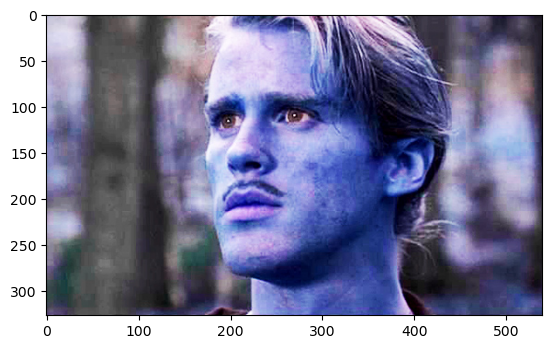

In [2]:
img = cv2.imread('./test_data/cary_elwes.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(img)

This block sets up the face and eye detection process. We first copy the original image to preserve it. Then we load the Haar cascade classifiers for face and eye detection. We detect faces in the grayscale image, and for each detected face, we look for eyes inside the face region. Rectangles are drawn around each face and eye, and the image is displayed in a separate window using OpenCV. 

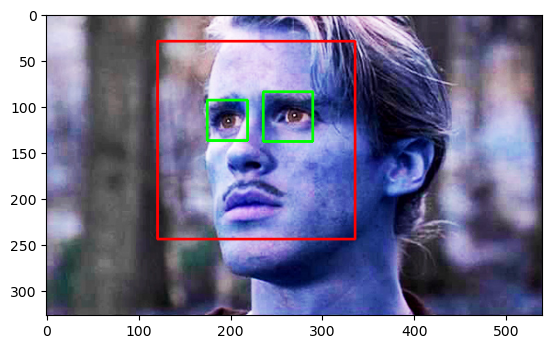

In [3]:
img_orig = img.copy()
face_cascade = cv2.CascadeClassifier('./haar_cascades_classifier/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./haar_cascades_classifier/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3,5) 

for (x,y,w,h) in faces:
    
    face_region_gray = gray[y:y+h, x:x+w] 
    face_region_color = img[y:y+h, x:x+w]
    
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    eyes =  eye_cascade.detectMultiScale(face_region_gray)
    
    for (x_eye, y_eye, w_eye, h_eye) in eyes:
        eyes_img = cv2.rectangle(face_region_color,(x_eye,y_eye),(x_eye+w_eye,y_eye+h_eye),(0,255,0),2)
    
plt.imshow(img)
img = img_orig

Here we define a helper function that takes an image path and attempts to detect face regions containing at least two eyes. The function returns a list of cropped face images, which will later be used for training or visualization.

In [4]:
def extract_face_regions(img_path, silent = True):
    
    face_regions = []  #here we will store clearly visible faces (faces with 2 eyes)
    
    img = cv2.imread(img_path)
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3,5)

    for (x,y,w,h) in faces:

        face_region_gray = gray[y:y+h, x:x+w] #face area gray
        face_region_color = img[y:y+h, x:x+w] #face area color

        eyes =  eye_cascade.detectMultiScale(face_region_gray)
        
        if len(eyes) >= 2:
            face_regions.append(face_region_color)
        
    if len(face_regions) == 0 and silent==False:
        print('No clear faces found.')
        
    return face_regions

Let's see the function in action! Here is what it does to the image of Cary Elwes we saw before.

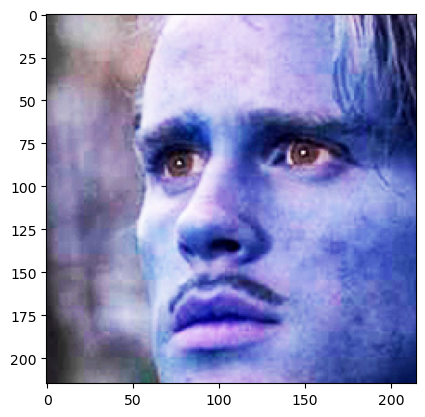

In [5]:
a = extract_face_regions('./test_data/cary_elwes.jpg', silent = False)
plt.imshow(a[0]);

Nice! Now let's see what the function does when we apply it to a photo with multiple faces.

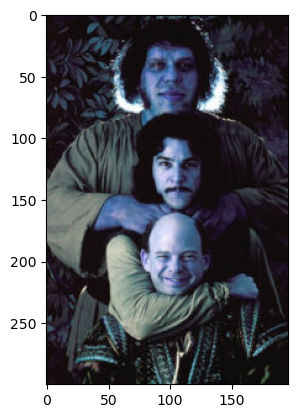

In [6]:
img =  cv2.imread('./test_data/multiple_people.jpg')
plt.imshow(img);

In [7]:
cr_faces = extract_face_regions('./test_data/multiple_people.jpg')
for cr_face in cr_faces:
    plt.figure()
    plt.imshow(cr_face)

This cell prepares the dataset for model training. It scans the raw_data directory to gather image folders and actor names, then recreates a directory for the cropped image data (cr_data), making a subdirectory for each actor.

In [8]:
path_raw_data = "./raw_data/"
path_cr_data = "./cr_data/"

img_folders = []
actor_names = []

for folder in os.scandir(path_raw_data):
    if folder.is_dir():
        img_folders.append(folder.path)
        actor_names.append(folder.name)
#If the cropped data folder was made in a previous run, we want to remove it and remake it
cr_data_folder = Path(path_cr_data)
if cr_data_folder.exists() and cr_data_folder.is_dir():
    shutil.rmtree(cr_data_folder)
os.mkdir(path_cr_data)

In [9]:
for name in actor_names:
    path_to_cr_actor = path_cr_data +'/'+ name
    if not os.path.exists(path_to_cr_actor):
        os.mkdir(path_to_cr_actor)

Now for each actor, we go through all the images in their raw data  folder and extract all the cropped faces from each image.  At the same time we make a directory, with the five actors'names as the keys, and the values are the paths to the cropped images of each actor.

In [13]:
cropped_img_dictionary = {}

for actor_ind in range(nr_actors):
    actor_name = actor_names[actor_ind]
    print(f"Currently going through pictures of {actor_name.replace('_', ' ')}.")
    cr_face_paths = []
    
    cropped_photo_ind = 0
    for image in os.scandir(img_folders[actor_ind]):
        
        path_to_image = img_folders[actor_ind] +'/'+image.name
        cr_faces = extract_face_regions(path_to_image)
        path_to_cr_actor = path_cr_data + actor_name
        for cr_face in cr_faces:
            
            cropped_photo_ind += 1

            cr_face_path = path_to_cr_actor + '/' +str(actor_name)  +str(cropped_photo_ind) +'.jpg'
            cv2.imwrite(cr_face_path, cr_face)
            cr_face_paths.append(cr_face_path)
            
    cropped_img_dictionary[actor_name] = cr_face_paths

Currently going through pictures of andre the giant.
Currently going through pictures of cary elwes.
Currently going through pictures of mandy patinkin.
Currently going through pictures of robin wright.
Currently going through pictures of wallace shawn.


When this is done, we go through each actor's directory of cropped face images and manually delete the photos of other people's faces. Next, we perform wavelet transformation on all the cropped face images.

# Feature engineering: wavelet transformation

Now we do the wavelet transformation to the cropped face images of each actor. This transform makes individual features (width of mouth, height of eyes etc) more descirnable. 

In [14]:
import pywt

In [15]:
# Thank you StackOverflow for this function.

def w2d(img, mode='haar', level=1):
    imArray = img
    
    #Datatype conversions
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY ) #convert to grayscale

    imArray =  np.float32(imArray)   #convert to float
    imArray /= 255;
    
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    
    # process coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

This scary looking image is the wavelet transform of the original image. We will combine it with the original image and then feed that into the model. 

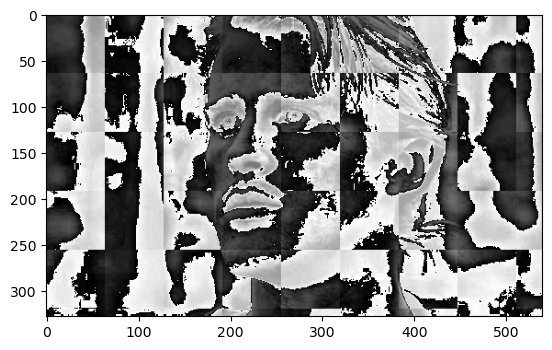

In [16]:
img = cv2.imread('./test_data/cary_elwes.jpg')
plt.imshow(w2d(img, 'db1', 6), cmap = 'gray');

In [17]:
labels = {}
for actor_ind in range(nr_actors):
    actor_name = actor_names[actor_ind]
    labels[actor_name] = actor_ind

In [18]:
X = [] #data
y = [] #labels

for actor_ind in range(nr_actors):
    actor_name = actor_names[actor_ind]
    print(actor_name)
    for img_path in cropped_img_dictionary[actor_name]:
        
        cr_img = cv2.imread(img_path)
        
        if cr_img is None: 
            continue
    
        cr_img_resized = cv2.resize(cr_img, (64,64)) 
        
        cr_img_trans = w2d(cr_img, 'db1', 5)
        cr_img_trans_resized = cv2.resize(cr_img_trans, (64,64)) 
    
        datapoint = np.vstack([cr_img_resized.reshape(64*64*3,1), cr_img_trans_resized.reshape(64*64,1)])
        X.append(datapoint)
                                    
        y.append(labels[actor_name])        
    
    

andre_the_giant
cary_elwes
mandy_patinkin
robin_wright
wallace_shawn


In [19]:
len_data = 64*64 *3 + 64*64
# sanity check
print(len(X[0]) == len_data)

#covert entries of feature vectors to floats
X = np.array(X).reshape(len(X), len_data)

True


Since we manually deleted some images from the cropped data folders, we must now remake the dictionary that contains for each actor the paths to the cropped photos we will use in training.

In [20]:
celebrity_file_names_dict =  {}
for name in actor_names:
    path_to_cr_actor = path_cr_data +'/'+ name
    file_list = []
    for img in os.scandir(path_to_cr_actor):
        file_list.append(img.path)
    celebrity_file_names_dict[name] = file_list

# Model training and CV

We are now ready to train our model. 
We begin by importing the necessary libraries. 

In [21]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 5))]) #scaling the data and then applying the model

pipe.fit(X_train, y_train) 
pipe.score(X_test, y_test)


0.8818181818181818

Not bad... Let's see if we can improve upon this score by including other models, and doing a systematic search to find the best model using 5-fold cross validation.

In [24]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressio
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [51]:
models = {
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto', max_iter = 200),
        'params': {'model__C': [1,5,10] } }, 
    
        'svm': {
        'model': svm.SVC(gamma='auto',probability=True), 
            'params' : {'model__C': [1,10,100], 'model__kernel': ['rbf','linear']} 
    },
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : { 'model__n_estimators': [1,5,10] }
    },
}

In [52]:
scores = [] 
best_estimators = {} #stores for each model class (log reg, svm, random forest) the best performing model

for algo, mp in models.items():
    # we make a pipeline that first scales the data and then applies the model to it
    pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', mp['model'])  
    ])
    
    #next, we perform a grid search with 5-fold cross validatio
    clf =  GridSearchCV(pipe, mp['params'], cv=5) 
    clf.fit(X_train, y_train)
    
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,logistic_regression,0.869044,{'model__C': 1}
1,svm,0.887179,"{'model__C': 1, 'model__kernel': 'linear'}"
2,random_forest,0.640280,{'model__n_estimators': 10}


It seems that SVMs and logistic regression perform best, and random forest performs quite poorly.

In [53]:
best_estimators['svm'].score(X_test,y_test) # F-score for the best SVM model

0.8909090909090909

In [54]:
best_estimators['random_forest'].score(X_test,y_test) # F-score for the best random forest model

0.6636363636363637

In [55]:
best_estimators['logistic_regression'].score(X_test,y_test) # F-score for the best log regression model

0.8909090909090909

Logistic regression and SVM have equal testing performance, but SVM has higher CV performance. Hence, I will use SVM as my final estimator.

''

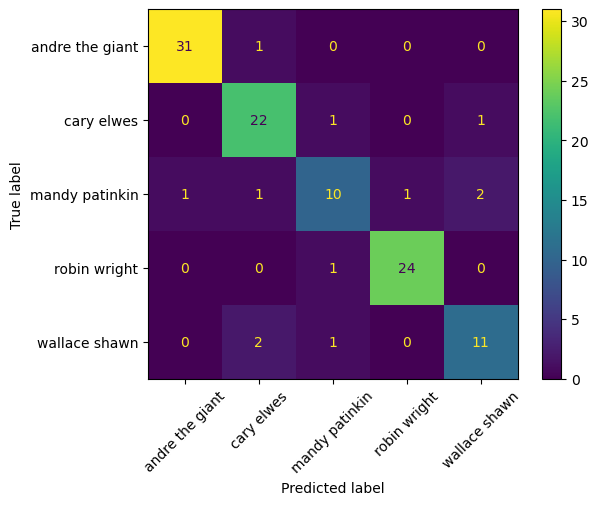

In [92]:
final_estimator = best_estimators['svm']

y_pred = final_estimator.predict(X_test)

# import the metrics class
from sklearn import metrics
import seaborn as sn

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

actor_names = [name.replace('_', ' ') for name in actor_names]

disp = metrics.ConfusionMatrixDisplay(cnf_matrix,  display_labels = actor_names)
disp.plot()
plt.xticks(rotation=45)
;


In [94]:
!pip install joblib
import joblib 
# Save the model as a pickle in a file 
joblib.dump(final_estimator, 'saved_model.pkl') 

import json
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(labels))